In [8]:
import pandas as pd
import json
import csv
from pathlib import Path
import mysql.connector as mariadb
from IPython.display import HTML, display
import tabulate
import matplotlib.pyplot as plt
import numpy as np

In [9]:
connection = mariadb.connect(user='root', password='')
cursor = connection.cursor()

cursor.execute("use nyctaxi;")

## Distância média em viagens com até dois passegeiros

In [10]:
cursor.execute("""
select FORMAT(avg(trip_distance),2) as dist_media from trips
where passenger_count <= 2;
""")
res = cursor.fetchone()
print('Distância média:', res[0])

Distância média: 2.66


## Três maiores vendors em dinheiro arrecadado

In [11]:
cursor.execute("""
select name as vendor,FORMAT(sum(total_amount),2) as total_arrecadado
from trips t inner join vendor_lookup v
on t.vendor_id = v.vendor_id 
group by t.vendor_id
order by sum(total_amount) desc
limit 3;
""")
res = cursor.fetchall()
display(HTML(tabulate.tabulate(res, tablefmt='html',headers=["Vendor","Total Arrecadado (USD)"])))

Vendor,Total Arrecadado (USD)
"Creative Mobile Technologies, LLC","19,549,084.28"
VeriFone Inc,"19,043,434.00"
"Dependable Driver Service, Inc","2,714,901.72"


## Distribuição mensal de corridas pagas em dinheiro

In [19]:
# Não há necessidade de usar a tabela payment_lookup pois não há outras variações de payment_type para 'Cash'
cursor.execute("""
select distinct payment_type from trips;
""")
cursor.fetchall()

[('Cash',), ('Credit',), ('No Charge',), ('Dispute',)]

In [20]:
cursor.execute("""
select 
substr(pickup_datetime from 6 for 2) as mes,
sum(payment_type = 'Cash') as viagens_dinheiro,
sum(payment_type <> 'Cash') as viagens_outros,
count(*) as viagens_tot
from trips 
group by substr(pickup_datetime from 6 for 2);
""")
res = cursor.fetchall()

<IPython.core.display.Javascript object>


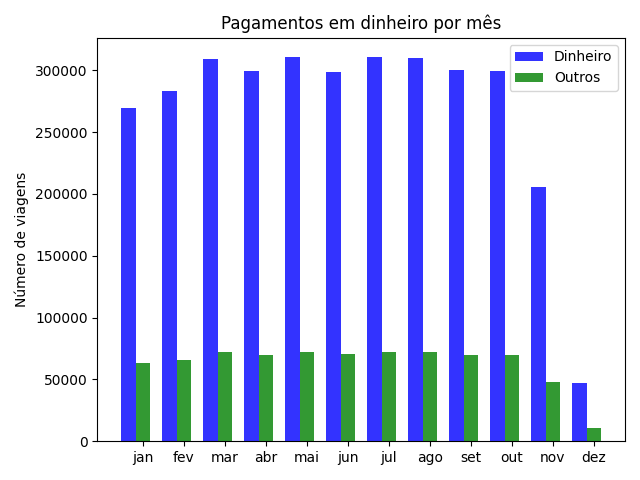

<IPython.core.display.Javascript object>


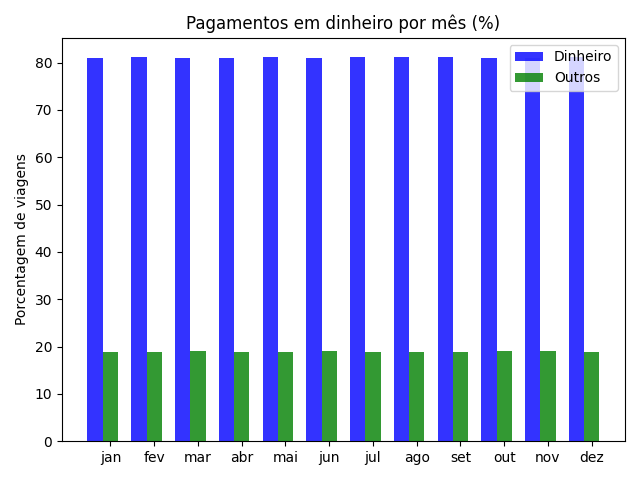

In [21]:
%matplotlib notebook
df = pd.DataFrame(res)

n_groups = 12
xlabels = ('jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez')

# Figura 1: total de viagens
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, df[1], bar_width,
alpha=opacity,
color='b',
label='Dinheiro')

rects2 = plt.bar(index + bar_width, df[2], bar_width,
alpha=opacity,
color='g',
label='Outros')

plt.ylabel('Número de viagens')
plt.title('Pagamentos em dinheiro por mês')
plt.xticks(index + bar_width, xlabels)
plt.legend()

plt.tight_layout()
plt.show()

# Figura 2: percentual de viagens
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, df[1]/df[3]*100, bar_width,
alpha=opacity,
color='b',
label='Dinheiro')

rects2 = plt.bar(index + bar_width, df[2]/df[3]*100, bar_width,
alpha=opacity,
color='g',
label='Outros')

plt.ylabel('Porcentagem de viagens')
plt.title('Pagamentos em dinheiro por mês (%)')
plt.xticks(index + bar_width, xlabels)
plt.legend()

plt.tight_layout()
plt.show()

## Total de gorjeta por dia nos últimos 3 meses de 2012

In [15]:
#O dataset não vai até o final do ano, portando vamos analisar os últimos 3 meses disponíveis
cursor.execute("""
select max(substr(pickup_datetime from 1 for 10)) as ultimo_dia
from trips;
""")
cursor.fetchone()

('2012-10-27',)

In [16]:
cursor.execute("""
select substr(pickup_datetime from 1 for 10) as dia,sum(tip_amount) as total_gorjeta 
from trips
where substr(pickup_datetime from 1 for 10) between '2012-07-27' and '2012-10-27'
group by substr(pickup_datetime from 1 for 10);
""")
res = cursor.fetchall()

<IPython.core.display.Javascript object>


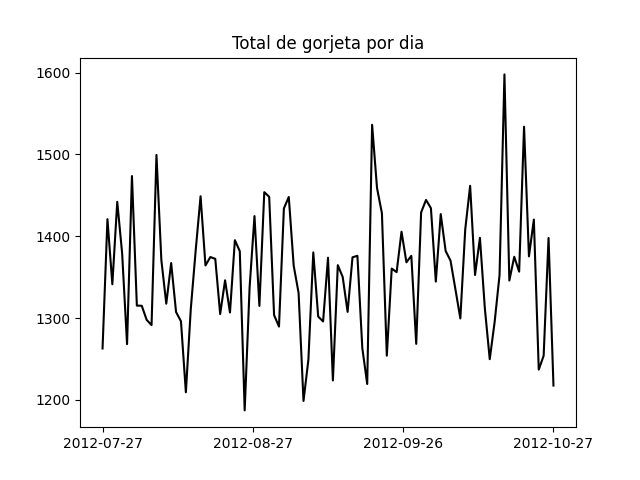

In [17]:
%matplotlib notebook
t = []
s = []

for record in res:
  t.append(record[0])
  s.append(record[1])
    
max = len(res)-1

plt.plot(t, s, 'k-')
plt.title("Total de gorjeta por dia")
_ = plt.xticks(np.linspace(0,max,4))